In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e2/sample_submission.csv
/kaggle/input/playground-series-s5e2/train.csv
/kaggle/input/playground-series-s5e2/test.csv
/kaggle/input/playground-series-s5e2/training_extra.csv
/kaggle/input/backpack-data/Noisy_Student_Bag_Price_Prediction_Dataset.csv


# Importing Modules:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import optuna
from sklearn.metrics import mean_squared_error, r2_score
import warnings 
warnings.filterwarnings('ignore')
# Disable LightGBM warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
import logging
logging.getLogger('lightgbm').setLevel(logging.INFO)
logging.getLogger('lightgbm').setLevel(logging.ERROR)

#Predicting Backpack price:

# Importing Data:

In [3]:
train_data = pd.read_csv(r"/kaggle/input/playground-series-s5e2/train.csv")
test_data = pd.read_csv(r"/kaggle/input/playground-series-s5e2/test.csv")
data = pd.read_csv(r"/kaggle/input/playground-series-s5e2/training_extra.csv")
sample_submission = pd.read_csv(r"/kaggle/input/playground-series-s5e2/sample_submission.csv")

print("train_data shape :",train_data.shape)
print("test_data shape :",test_data.shape)
print("data shape :",data.shape)
print("sample_submission shape :",sample_submission.shape)

train_data shape : (300000, 11)
test_data shape : (200000, 10)
data shape : (3694318, 11)
sample_submission shape : (200000, 2)


In [4]:
train_data.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB


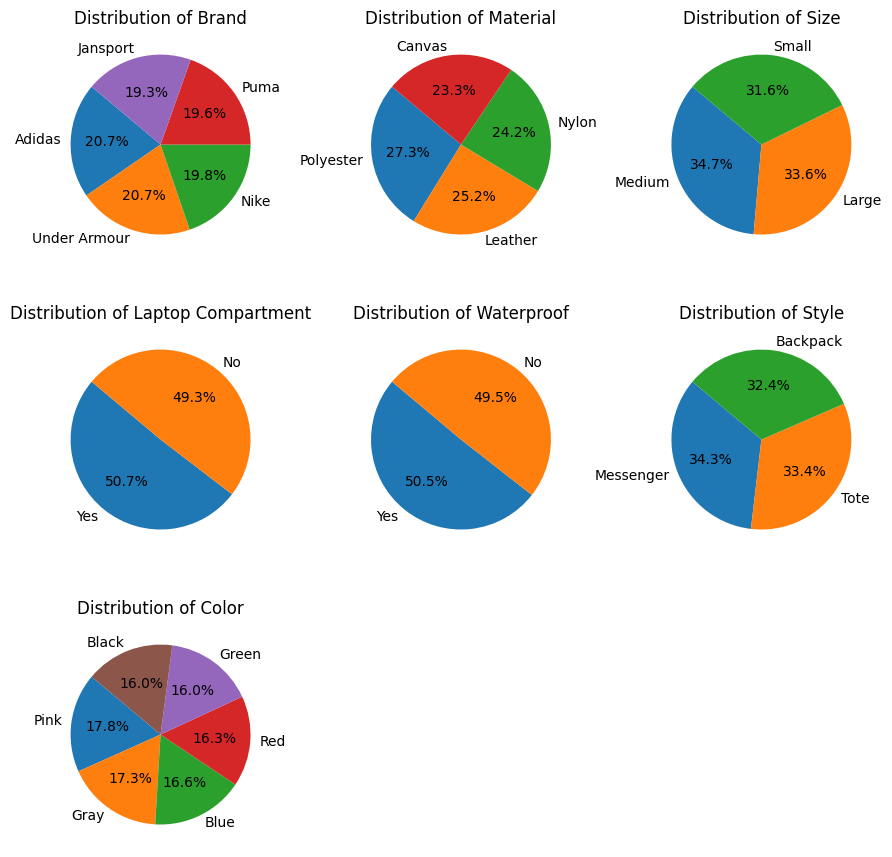

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Identify categorical columns
cat_cols = train_data.select_dtypes(include=["object", "category"]).columns.tolist()

# Define subplot grid (3 rows, auto columns)
num_plots = len(cat_cols)
rows = 3
cols = (num_plots // rows) + (num_plots % rows > 0)  # Adjust columns dynamically

fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
axes = axes.flatten()  # Flatten for easy indexing

# Plot each categorical column
for i, col in enumerate(cat_cols):
    value_counts = train_data[col].value_counts()
    axes[i].pie(value_counts, labels=value_counts.index, autopct="%1.1f%%", startangle=140)
    axes[i].set_title(f"Distribution of {col}")

# Hide unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [7]:
train_data.isna().sum().sort_values(ascending=False)

Color                   9950
Brand                   9705
Material                8347
Style                   7970
Laptop Compartment      7444
Waterproof              7050
Size                    6595
Weight Capacity (kg)     138
id                         0
Compartments               0
Price                      0
dtype: int64

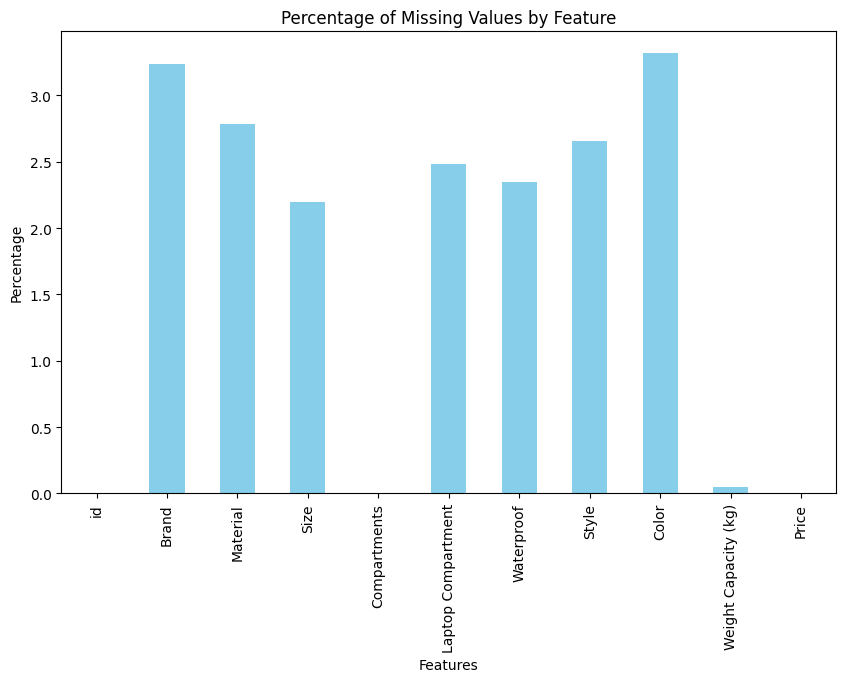

In [8]:
# Calculate missing values
missing_values = train_data.isnull().mean() * 100

# Plot
missing_values.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Percentage of Missing Values by Feature')
plt.ylabel('Percentage')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.show()

In [9]:
#train_data = train_data.dropna()
train_data.shape

(300000, 11)

In [10]:
data.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,500000,Under Armour,Canvas,Small,10.0,Yes,Yes,Tote,Blue,23.882052,114.11068
1,500001,Puma,Polyester,Small,4.0,No,Yes,Backpack,Green,11.869095,129.74972
2,500002,Jansport,Polyester,Small,8.0,Yes,Yes,Tote,Red,8.092302,21.37370
3,500003,Nike,Nylon,Large,7.0,No,No,Messenger,Pink,7.719581,48.09209
4,500004,Nike,Leather,Large,9.0,No,Yes,Tote,Green,22.741826,77.32461


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3694318 entries, 0 to 3694317
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Brand                 object 
 2   Material              object 
 3   Size                  object 
 4   Compartments          float64
 5   Laptop Compartment    object 
 6   Waterproof            object 
 7   Style                 object 
 8   Color                 object 
 9   Weight Capacity (kg)  float64
 10  Price                 float64
dtypes: float64(3), int64(1), object(7)
memory usage: 310.0+ MB


In [12]:
data.isnull().sum().sort_values(ascending=False)

Color                   123667
Brand                   117053
Material                102615
Style                    96210
Laptop Compartment       91089
Waterproof               87274
Size                     81190
Weight Capacity (kg)      1670
id                           0
Compartments                 0
Price                        0
dtype: int64

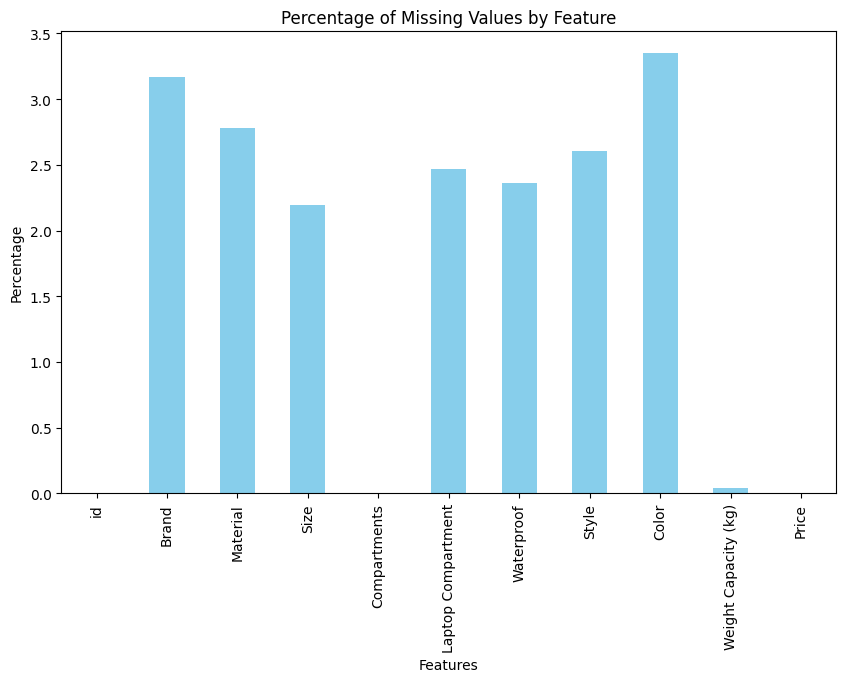

In [13]:
# Calculate missing values
missing_values = data.isnull().mean() * 100

# Plot
missing_values.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Percentage of Missing Values by Feature')
plt.ylabel('Percentage')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.show()

In [14]:
data.describe()

,id,Compartments,Weight Capacity (kg),Price
count,3.694318e+06,3.694318e+06,3.692648e+06,3.694318e+06
mean,2.347158e+06,5.434022e+00,1.800883e+01,8.135820e+01
std,1.066458e+06,2.893227e+00,6.974541e+00,3.893050e+01
min,5.000000e+05,1.000000e+00,5.000000e+00,1.500000e+01
25%,1.423579e+06,3.000000e+00,1.206854e+01,4.747778e+01
50%,2.347158e+06,5.000000e+00,1.805243e+01,8.098592e+01
75%,3.270738e+06,8.000000e+00,2.398580e+01,1.148434e+02
max,4.194317e+06,1.000000e+01,3.000000e+01,1.500000e+02


In [15]:
data = data.dropna()
data.shape

(3041817, 11)

In [16]:
# Distribution of the data:
#data.hist(figsize=(10,5),color = 'skyblue', edgecolor='black')
#plt.show()

In [17]:
# Distribution of the data:
#train_data.drop(['id'],axis=1).hist(figsize=(10,5),color = 'skyblue', edgecolor='black')
#plt.show()

In [18]:
test_data.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,300000,Puma,Leather,Small,2.0,No,No,Tote,Green,20.671147
1,300001,Nike,Canvas,Medium,7.0,No,Yes,Backpack,Green,13.564105
2,300002,Adidas,Canvas,Large,9.0,No,Yes,Messenger,Blue,11.809799
3,300003,Adidas,Nylon,Large,1.0,Yes,No,Messenger,Green,18.477036
4,300004,NaN,Nylon,Large,2.0,Yes,Yes,Tote,Black,9.907953


In [19]:
test_data.isna().sum().sort_values(ascending=False)

Color                   6785
Brand                   6227
Material                5613
Style                   5153
Laptop Compartment      4962
Waterproof              4811
Size                    4381
Weight Capacity (kg)      77
id                         0
Compartments               0
dtype: int64

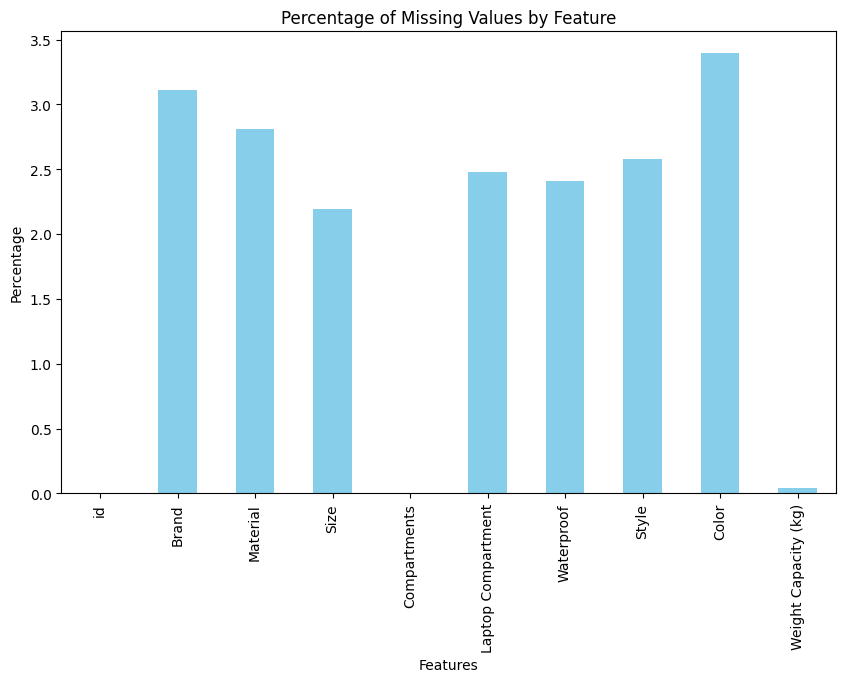

In [20]:
# Calculate missing values
missing_values = test_data.isnull().mean() * 100

# Plot
missing_values.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Percentage of Missing Values by Feature')
plt.ylabel('Percentage')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.show()

# Merging original and train data:

In [21]:
#train_data = train_data.drop("id", axis=1)
#test_data = test_data.drop("id", axis=1)
train_data = pd.concat([train_data, data], ignore_index=True)
train_data = train_data.drop("id", axis=1)
train_data = train_data.drop_duplicates()
print("shape of the data :",train_data.shape)

shape of the data : (3341817, 10)


In [22]:
train_data.head(2)

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056


In [23]:
#train_data = train_data.fillna('missing')
#test_data = test_data.fillna('missing')

In [24]:
#train_data = train_data.drop('id', axis = 1)
num_cols = list(train_data.select_dtypes(exclude=['object']).columns.difference(['Price']))
cat_cols = list(train_data.select_dtypes(include=['object']).columns)

num_cols_test = list(test_data.select_dtypes(exclude=['object']).columns.difference(['id']))
cat_cols_test = list(test_data.select_dtypes(include=['object']).columns)

In [25]:
# Fill missing values
train_data[train_data.select_dtypes(include=['number']).columns] = train_data.select_dtypes(include=['number']).apply(lambda x: x.fillna(x.median()))
train_data[train_data.select_dtypes(include=['object']).columns] = train_data.select_dtypes(include=['object']).apply(lambda x: x.fillna("missing").astype('category'))

# Fill missing values
test_data[test_data.select_dtypes(include=['number']).columns] = test_data.select_dtypes(include=['number']).apply(lambda x: x.fillna(x.median()))
test_data[test_data.select_dtypes(include=['object']).columns] = test_data.select_dtypes(include=['object']).apply(lambda x: x.fillna("missing").astype('category'))

# Using ANOVA (F-statistic)
ANOVA tests whether the means of the target variable differ significantly across different categories. Higher F-values indicate stronger correlation.

In [26]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway

def anova_correlation(train_data, cat_cols, target_col):
    results = {}
    for col in cat_cols:
        groups = [train_data[target_col][train_data[col] == category] for category in train_data[col].unique()]
        f_stat, p_value = f_oneway(*groups)
        results[col] = f_stat  # Higher F-statistic means stronger relation
    return results

# Identify categorical columns
#categorical_cols = ['cat_col1', 'cat_col2']  # Replace with your categorical column names
anova_results = anova_correlation(train_data, cat_cols, 'Price')

# Display sorted results
sorted(anova_results.items(), key=lambda x: x[1], reverse=True)

#Interpretation: Higher F-values mean stronger correlation between the categorical column and the numerical target.

[('Material', 216.680634863224),
 ('Color', 166.64294246054672),
 ('Brand', 125.7290624239343),
 ('Size', 37.09278301623845),
 ('Waterproof', 24.639914974694413),
 ('Laptop Compartment', 13.237918456356843),
 ('Style', 12.411641518899089)]

# Using Mean Encoding with Pearson Correlation
Another approach is to replace each category with its mean target value and then compute Pearson correlation.

In [27]:
from scipy.stats import pearsonr

def mean_encoding_correlation(train_data, cat_cols, target_col):
    correlations = {}
    for col in cat_cols:
        mean_encoded = train_data.groupby(col)[target_col].transform('mean')
        correlation, _ = pearsonr(mean_encoded, train_data[target_col])
        correlations[col] = correlation
    return correlations

mean_corr_results = mean_encoding_correlation(train_data, cat_cols, 'Price')

# Display sorted results
sorted(mean_corr_results.items(), key=lambda x: abs(x[1]), reverse=True)

#Interpretation:
#1. A high absolute correlation value (close to 1 or -1) indicates a strong relationship.
#2. Values closer to 0 suggest little or no correlation.

[('Color', 0.017294708674861624),
 ('Material', 0.01610247846050935),
 ('Brand', 0.013714218158198946),
 ('Size', 0.005770414814795909),
 ('Waterproof', 0.003840079902912263),
 ('Style', 0.0033379647615568333),
 ('Laptop Compartment', 0.0028146992098825657)]

# Encoding data:

In [28]:
# Convert all categorical columns to string type
#train_data[cat_cols] = train_data[cat_cols].astype(str)
#test_data[cat_cols] = test_data[cat_cols].astype(str)
# Initialize LabelEncoder
label_encoders = {col: LabelEncoder() for col in cat_cols}

# Apply LabelEncoder to each categorical column
for col in cat_cols:
    train_data[col] = label_encoders[col].fit_transform(train_data[col])
    test_data[col] = label_encoders[col].transform(test_data[col])

# Scaling data:

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data[num_cols] = scaler.fit_transform(train_data[num_cols])
test_data[num_cols_test] = scaler.transform(test_data[num_cols_test])

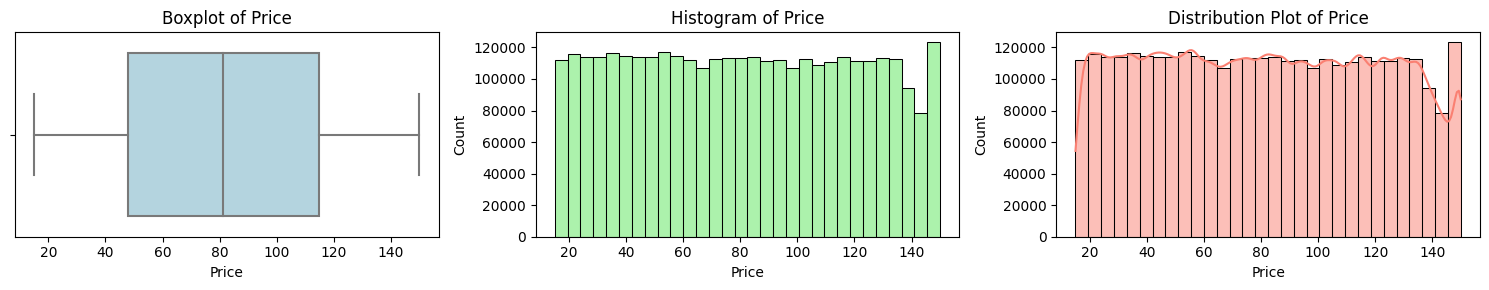

In [30]:
# Create the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

# Boxplot
sns.boxplot(x=train_data["Price"], ax=axes[0], color='lightblue')
axes[0].set_title("Boxplot of Price")

# Histogram
sns.histplot(train_data["Price"], bins=30, kde=False, ax=axes[1], color='lightgreen')
axes[1].set_title("Histogram of Price")

# Distribution plot (KDE + Histogram)
sns.histplot(train_data["Price"], bins=30, kde=True, ax=axes[2], color='salmon')
axes[2].set_title("Distribution Plot of Price")

# Show the plots
plt.tight_layout()
plt.show()

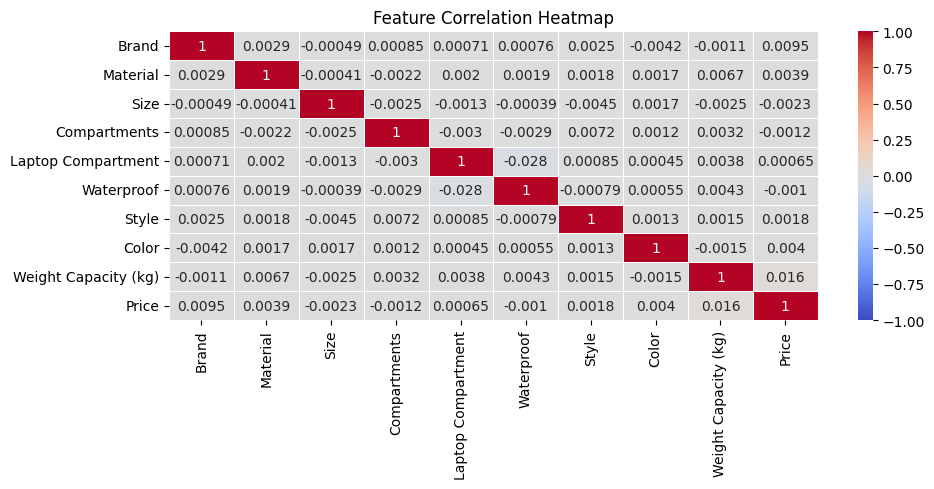

In [31]:
# Calculate the correlation matrix
correlation_matrix = train_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [32]:
train_data['Compartments'] = train_data['Compartments'].astype('object')
test_data['Compartments'] = test_data['Compartments'].astype('object')
train_data['Weight Capacity (kg)'] = train_data['Weight Capacity (kg)'].astype('object')
test_data['Weight Capacity (kg)'] = test_data['Weight Capacity (kg)'].astype('object')

In [33]:
train_data.head(2)

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,1,1,1,0.539636,1,0,2,0,-0.916627,112.15875
1,1,0,2,1.577997,1,1,1,3,1.303091,68.88056


# Splitting Data:

In [34]:
X = train_data.drop(['Price'], axis=1)
y = train_data['Price']
test = test_data.drop(['id'],axis=1)

# Split datainto training set and test set
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# CatBoostRegressor:

In [35]:
parameters ={'iterations': 900, 'depth': 5, 'learning_rate': 0.06687502193263943, 'l2_leaf_reg': 0.009012725660552562, 'border_count': 201, 'random_strength': 4.410487182794549, 'bagging_temperature': 6.804257115462372}
#value: 38.64661057765384.

Fold RMSE: 38.6465
Fold RMSE: 38.6358
Fold RMSE: 38.6197
Fold RMSE: 38.6356
Fold RMSE: 38.6308

Mean RMSE across folds: 38.6337
       id      Price
0  300000  79.626981
1  300001  82.280809
2  300002  82.857582
3  300003  79.519822
4  300004  80.934829


<Axes: >

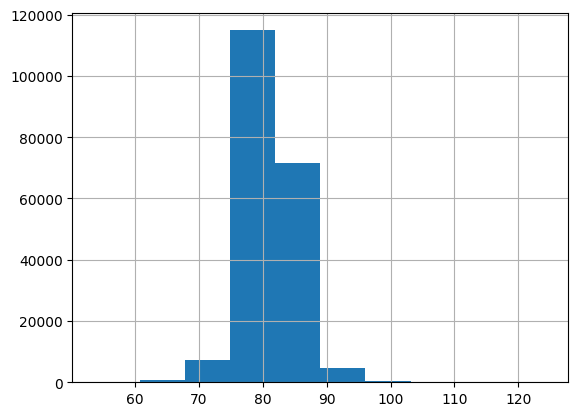

In [36]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# Convert categorical columns to string type
for col in X.columns:
    X[col] = X[col].astype(str)
    test[col] = test[col].astype(str)

# Identify categorical features
cat_features = X.columns.tolist()

# Initialize K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-Fold CV
rmse_scores = []
preds = []

# Perform K-Fold CV
for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Convert to CatBoost Pool
    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    val_pool = Pool(X_val, y_val, cat_features=cat_features)
    
    # Initialize CatBoost Regressor
    model = CatBoostRegressor(**parameters,
        loss_function="RMSE",
        cat_features=cat_features,
        verbose=0
    )

    # Train model
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, use_best_model=True)

    # Predict & compute RMSE
    y_pred = model.predict(X_val)
    pred = model.predict(test)
    preds.append(pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores.append(rmse)
    print(f"Fold RMSE: {rmse:.4f}")

# Print Mean RMSE across folds
mean_rmse = np.mean(rmse_scores)
print(f"\nMean RMSE across folds: {mean_rmse:.4f}")

cat_preds = np.mean(preds, axis=0)
submission_cat = pd.DataFrame({'id': test_data.id, 'Price': cat_preds})
print(submission_cat.head())
submission_cat.to_csv('submission_cat.csv', index=False)

submission_cat['Price'].hist()
#Mean RMSE across folds: 38.6339

RMSE scores for each fold: [38.784731946802935, 38.72031675140477, 38.84848418191683, 38.80991156551571, 38.8039973246975]
Average RMSE: 38.79348835406755
       id      Price
0  300000  80.928038
1  300001  82.285984
2  300002  82.916590
3  300003  81.234731
4  300004  77.445990


<Axes: >

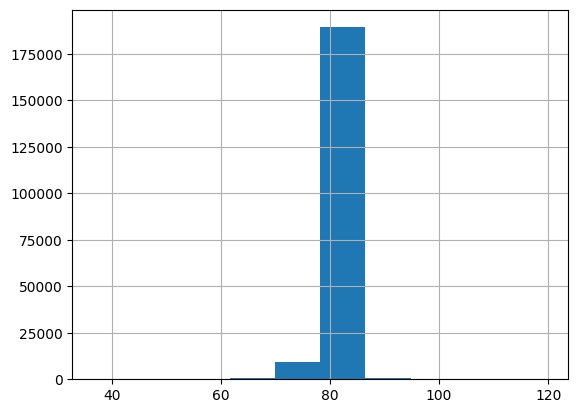

In [37]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Initialize K-Fold cross-validator
kf = KFold(n_splits=5, shuffle=True)

# Initialize lists to store results
rmse_scores = []
preds = []

# Initialize the model
model = CatBoostRegressor(**parameters,verbose=0,loss_function='RMSE',eval_metric= 'RMSE',random_state=42)

# K-Fold Cross-Validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)
    pred = model.predict(test)
    preds.append(pred)

    # Calculate RMSE
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse_scores.append(rmse)

# Calculate the average RMSE across all folds
avg_rmse = np.mean(rmse_scores)

# Print RMSE for each fold and the average RMSE
print("RMSE scores for each fold:", rmse_scores)
print("Average RMSE:", avg_rmse)

cat_preds = np.mean(preds, axis=0)
submission_cat = pd.DataFrame({'id': test_data.id, 'Price': cat_preds})
print(submission_cat.head())
submission_cat.to_csv('submission_cat1.csv', index=False)

submission_cat['Price'].hist()
#Average RMSE: 38.7940188825754

# XGBRegressor:

In [38]:
xgb_parameters = {'n_estimators': 3649, 'learning_rate': 0.03618354865553652, 'max_depth': 3, 'min_child_weight': 4.711257151527733, 'subsample': 0.7574455337411672, 'colsample_bytree': 0.9119856086671668, 'lambda': 0.000937201633995687, 'alpha': 3.060383912120667}
#Best RMSE: 38.9996526675085
parameters = {'n_estimators': 1980, 'learning_rate': 0.019016829187088413, 'max_depth': 4, 'min_child_weight': 1.2576362814382727, 'subsample': 0.8551673209374542, 'colsample_bytree': 0.9666608128642872, 'lambda': 3.353364908451519e-05, 'alpha': 1.0945466337127865}
#value: 38.793353567386134.

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
# Initialize K-Fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
rmse_scores = []
preds = []
# Initialize the model
model = XGBRegressor(**parameters,loss_function='RMSE',random_state=42)

# K-Fold Cross-Validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)
    pred = model.predict(test)
    preds.append(pred)

    # Calculate RMSE
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse_scores.append(rmse)

# Calculate the average RMSE across all folds
avg_rmse = np.mean(rmse_scores)

# Print RMSE for each fold and the average RMSE
print("RMSE scores for each fold:", rmse_scores)
print("Average RMSE:", avg_rmse)

xgb_preds = np.mean(preds, axis=0)
submission_xgb = pd.DataFrame({'id': test_data.id, 'Price': xgb_preds})
print(submission_xgb.head())
submission_xgb.to_csv('submission_xgb.csv', index=False)

submission_xgb['Price'].hist()

# LGBMRegressor:

In [39]:
lgb_parameters = {'n_estimators': 1267, 'learning_rate': 0.010657512662509413, 'max_depth': 3, 'num_leaves': 42, 'min_child_samples': 48, 'subsample': 0.5643136402119217, 'colsample_bytree': 0.8624225587120392, 'reg_alpha': 0.011441404961226555, 'reg_lambda': 0.0712926757533912}
#Best RMSE: 39.01458863233762
lgbparameters = {'n_estimators': 545, 'learning_rate': 0.022486051953875208, 'max_depth': 3, 'num_leaves': 115, 'min_child_samples': 76, 'subsample': 0.995811529438896, 'colsample_bytree': 0.7158057062872807, 'reg_alpha': 0.004169813199994837, 'reg_lambda': 0.4756560131839915}
#Best RMSE: 39.01198791552696

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Initialize K-Fold cross-validator
kf = KFold(n_splits=5, shuffle=True)

# Initialize lists to store results
rmse_scores = []
preds = []

# Initialize the model
model = LGBMRegressor(**lgb_parameters,verbosity=-1,loss_function='RMSE',eval_metric= 'RMSE',random_state=42,boosting_type="gbdt")

# K-Fold Cross-Validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)
    pred = model.predict(test)
    preds.append(pred)

    # Calculate RMSE
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse_scores.append(rmse)

# Calculate the average RMSE across all folds
avg_rmse = np.mean(rmse_scores)

# Print RMSE for each fold and the average RMSE
print("RMSE scores for each fold:", rmse_scores)
print("Average RMSE:", avg_rmse)

lgb_preds =  np.mean(preds, axis=0)
submission_lgb = pd.DataFrame({'id': test_data.id, 'Price': lgb_preds})
print(submission_lgb.head())
submission_lgb.to_csv('submission_lgb.csv', index=False)

submission_lgb['Price'].hist()

preds = cat_preds*0.22 + lgb_preds*0.28 + xgb_preds*0.5
submission = pd.DataFrame({'id': test_data.id, 'Price': preds})
print(submission.head())
submission.to_csv('submission_blend.csv', index=False)

submission['Price'].hist()